In [1]:
import pandas as pd
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
import river.metrics as metrics
import river.stream as stream

In [2]:
#!pip install deep-river
#!pip install prettytable
#!pip install tabulate

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from torch import nn, manual_seed
from torch.nn import functional as F
from IPython.display import clear_output
from collections import deque, Counter
from river import metrics, preprocessing, compose, stream
from deep_river import classification

In [4]:
offline_df = pd.read_csv('CICIoMT2024/Train.csv')
offline_df = offline_df.sample(frac=0.01, random_state=42)

In [5]:
online_df = pd.read_csv('CICIoMT2024/Test.csv')
online_df = online_df.sample(frac=0.1, random_state=42)

In [6]:
offline_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71557 entries, 6612853 to 3840050
Data columns (total 46 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Header_Length    71557 non-null  float64
 1   Protocol Type    71557 non-null  float64
 2   Duration         71557 non-null  float64
 3   Rate             71557 non-null  float64
 4   Srate            71557 non-null  float64
 5   Drate            71557 non-null  float64
 6   fin_flag_number  71557 non-null  float64
 7   syn_flag_number  71557 non-null  float64
 8   rst_flag_number  71557 non-null  float64
 9   psh_flag_number  71557 non-null  float64
 10  ack_flag_number  71557 non-null  float64
 11  ece_flag_number  71557 non-null  float64
 12  cwr_flag_number  71557 non-null  float64
 13  ack_count        71557 non-null  float64
 14  syn_count        71557 non-null  float64
 15  fin_count        71557 non-null  float64
 16  rst_count        71557 non-null  float64
 17  HTTP     

In [7]:
online_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 161212 entries, 1088358 to 315349
Data columns (total 46 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Header_Length    161212 non-null  float64
 1   Protocol Type    161212 non-null  float64
 2   Duration         161212 non-null  float64
 3   Rate             161212 non-null  float64
 4   Srate            161212 non-null  float64
 5   Drate            161212 non-null  float64
 6   fin_flag_number  161212 non-null  float64
 7   syn_flag_number  161212 non-null  float64
 8   rst_flag_number  161212 non-null  float64
 9   psh_flag_number  161212 non-null  float64
 10  ack_flag_number  161212 non-null  float64
 11  ece_flag_number  161212 non-null  float64
 12  cwr_flag_number  161212 non-null  float64
 13  ack_count        161212 non-null  float64
 14  syn_count        161212 non-null  float64
 15  fin_count        161212 non-null  float64
 16  rst_count        161212 non-null  flo

In [8]:
print(offline_df['Label'].value_counts())

Label
DDoS-UDP              16235
DDoS-ICMP             15475
DDoS-SYN               8134
DDoS-TCP               8008
DoS-UDP                5660
DoS-SYN                4408
DoS-ICMP               4189
DoS-TCP                3810
Benign                 1914
DDoS-Connect_Flood     1707
Port_Scan               747
DoS-Publish_Flood       441
DDoS-Publish_Flood      300
ARP_Spoofing            165
OS_Scan                 163
DoS-Connect_Flood       129
Malformed_Data           48
VulScan                  18
Ping_Sweep                6
Name: count, dtype: int64


In [9]:
print(online_df['Label'].value_counts())

Label
DDoS-UDP              36400
DDoS-ICMP             34910
DDoS-TCP              18381
DDoS-SYN              17231
DoS-UDP               13711
DoS-SYN                9881
DoS-ICMP               9781
DoS-TCP                8086
DDoS-Connect_Flood     4109
Benign                 3789
Port_Scan              2129
DoS-Publish_Flood       896
DDoS-Publish_Flood      815
OS_Scan                 341
DoS-Connect_Flood       282
Malformed_Data          185
ARP_Spoofing            167
VulScan                  89
Ping_Sweep               29
Name: count, dtype: int64


In [10]:
# Creating a dictionary of Types
attacks = {'DDoS-UDP':0, 
           'DDoS-ICMP':1,
           'DDoS-TCP':2,
           'DDoS-SYN':3,
           'DoS-UDP':4,
           'DoS-SYN':5, 
           'DoS-ICMP':6, 
           'DoS-TCP':7, 
           'DDoS-Connect_Flood':8,           
           'Benign':9,
           'Port_Scan':10,
           'DoS-Publish_Flood':11, 
           'DDoS-Publish_Flood':12,
           'OS_Scan':13,
           'DoS-Connect_Flood':14, 
           'Malformed_Data':15, 
           'ARP_Spoofing':16,
           'VulScan':17, 
           'Ping_Sweep':18}

offline_df['Label'] = offline_df['Label'].map(attacks)
online_df['Label'] = online_df['Label'].map(attacks)

# Train Offline Model

In [11]:
X_train = offline_df.drop(columns=['Label'])
y_train = offline_df['Label']
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [12]:
# Offline training setup
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

offline_model = RandomForestClassifier()
offline_model.fit(X_train, y_train)

RandomForestClassifier()

# Initialize Online Model

In [13]:
# Set random seed for reproducibility
manual_seed(42)

# Split features and labels
X = online_df.drop(columns=['Label'])
y = online_df['Label']
X, y = shuffle(X, y, random_state=42)

In [14]:
class MyCNN(nn.Module):
    def __init__(self, n_features):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)  # Match LSTM hidden size
        self.fc = nn.Linear(32 * (n_features // 4), 19)  # Match LSTM final output
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, X, **kwargs):
        X = X.unsqueeze(1)  # Add a channel dimension for Conv1D
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        X = X.view(X.size(0), -1)  # Flatten tensor
        X = self.softmax(self.fc(X))
        return X

In [15]:
# Initialize the online model pipeline
model_pipeline = preprocessing.StandardScaler() | classification.Classifier(
    module=MyCNN,    
    loss_fn='cross_entropy',
    optimizer_fn='adam'
)

In [16]:
# Real-time metrics setup for multi-class evaluation
metrics_dict = {
    'Accuracy': metrics.Accuracy(),    
    'Precision': metrics.MacroPrecision(),  # Macro-average for multi-class
    'Recall': metrics.MacroRecall(),
    'F1-score': metrics.MacroF1()
}

In [17]:
# Lists for tracking metrics over time for visualization
accuracy_values, precision_values, recall_values, f1_values = [], [], [], []

In [18]:
# Buffer for recent prediction accuracy
accuracy_buffer_offline = deque(maxlen=100)
accuracy_buffer_online = deque(maxlen=100)

In [19]:
# Set accuracy threshold for triggering online model updates
accuracy_threshold = 0.99  # Define your acceptable threshold

In [20]:
# Real-time metrics visualization function
def plot_metrics():
    clear_output(wait=True)    
    plt.figure(figsize=(14, 8))    
    plt.plot(accuracy_values, label='Accuracy', color='blue', linestyle='--', alpha=0.7)    
    plt.plot(precision_values, label='Precision', color='green', linestyle='--', alpha=0.7)        
    plt.plot(recall_values, label='Recall', color='orange', linestyle='--', alpha=0.7)        
    plt.plot(f1_values, label='F1-Score', color='red', linestyle='--', alpha=0.7)
        
    # Set title and labels
    plt.title('Real-Time Metrics for Hybrid Model')
    plt.xlabel('Number of Samples')
    plt.ylabel('Metric Value')
    
    # Add grid and legend
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(loc='best')
    
    # Show plot   
    plt.show()

In [21]:
# Helper function to update accuracy buffer
def update_accuracy_buffer(buffer, y_true, y_pred):
    buffer.append(int(y_true == y_pred))
    return sum(buffer) / len(buffer)

In [22]:
# Streaming the dataset
dataset = stream.iter_pandas(X, y)
num_samples = 0

In [23]:
# Initialize tracking variables
num_updates = 0
agreement_count = 0
confidence_scores = []
total_time = 0
degradation_instances = 0
hybrid_predictions = []

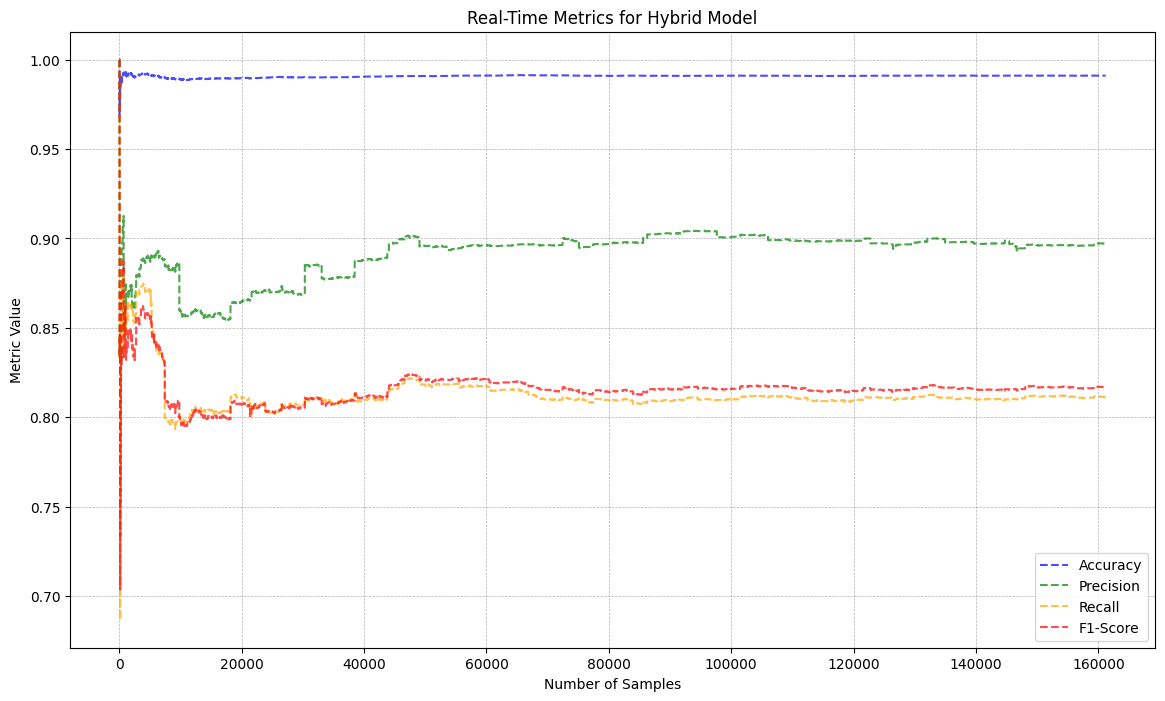

In [24]:
# Main loop for hybrid prediction
for x, y in dataset:
    start_time = time.time()  # Start time for runtime measurement
    
    num_samples += 1
    x_scaled = scaler.transform(pd.DataFrame([x]))  # Scale each streamed instance
    y_pred_offline = offline_model.predict(x_scaled)[0]
    y_pred_online = model_pipeline.predict_one(x)

    # Update accuracy buffers
    offline_accuracy = update_accuracy_buffer(accuracy_buffer_offline, y, y_pred_offline)
    online_accuracy = update_accuracy_buffer(accuracy_buffer_online, y, y_pred_online)

    # Decision logic: Select prediction from model with higher recent accuracy
    y_pred = y_pred_online if online_accuracy >= offline_accuracy else y_pred_offline

    # Check agreement between offline and online models
    if y_pred_offline == y_pred_online:
        agreement_count += 1

    # Append prediction to hybrid_predictions list
    hybrid_predictions.append(y_pred)

     # Calculate confidence score for online prediction, if available
    y_pred_online_prob = model_pipeline.predict_proba_one(x)
    confidence_score = max(y_pred_online_prob.values()) if y_pred_online_prob else None
    if confidence_score is not None:
        confidence_scores.append(confidence_score)

    # Update real-time metrics
    for name, metric in metrics_dict.items():
        metric.update(y, y_pred)
    
    # Append latest metrics for visualization
    accuracy_values.append(metrics_dict['Accuracy'].get())    
    precision_values.append(metrics_dict['Precision'].get())
    recall_values.append(metrics_dict['Recall'].get())
    f1_values.append(metrics_dict['F1-score'].get())
       
    # Online model learning triggered by accuracy threshold
    if online_accuracy < accuracy_threshold:
        model_pipeline.learn_one(x, y)
        num_updates += 1
        degradation_instances += 1
           
    # Plot metrics every 50 samples
    if num_samples % 50 == 0:
        plot_metrics()

    # Runtime calculation
    end_time = time.time()
    total_time += (end_time - start_time)

In [25]:
# Final results after streaming
print("Final Performance Metrics of Hybrid Model:")
for name, metric in metrics_dict.items():
    print(f"{name}: {metric.get():.4f}")

Final Performance Metrics of Hybrid Model:
Accuracy: 0.9911
Precision: 0.8972
Recall: 0.8112
F1-score: 0.8165


In [26]:
# Reverse the dictionary to map index to attack type
index_to_attack = {v: k for k, v in attacks.items()}

# Determine the predicted attack type
predicted_attack_type = index_to_attack.get(y_pred, "Unknown")
online_prediction_type = index_to_attack.get(y_pred_online, "Unknown")

# Generate Hybrid Model Prediction Distribution
hybrid_pred_distribution = Counter(hybrid_predictions)
hybrid_distribution_table = pd.DataFrame([
    {"Attack Type": index_to_attack.get(k, "Unknown"), "Count": v}
    for k, v in hybrid_pred_distribution.items()
])

# Print Results as Table and Case Description
case_description = {
    "Processed Samples": num_samples,
    "Predicted Attack Type": predicted_attack_type,
    "Model Source": "Online" if y_pred == y_pred_online else "Offline",
}

# Display Results
print("Case Description:")
print(pd.DataFrame([case_description]))

print("\nHybrid Model Prediction Distribution:")
print(hybrid_distribution_table)

Case Description:
   Processed Samples Predicted Attack Type Model Source
0             161212             DDoS-ICMP       Online

Hybrid Model Prediction Distribution:
           Attack Type  Count
0            DDoS-ICMP  34912
1             DDoS-SYN  17186
2             DDoS-UDP  36423
3             DoS-ICMP   9757
4               Benign   3951
5   DDoS-Connect_Flood   4113
6             DDoS-TCP  18364
7              DoS-TCP   8098
8              DoS-SYN   9886
9              DoS-UDP  13734
10   DoS-Publish_Flood   1631
11             OS_Scan    210
12           Port_Scan   2195
13        ARP_Spoofing    247
14      Malformed_Data    103
15   DoS-Connect_Flood    280
16  DDoS-Publish_Flood     83
17          Ping_Sweep     18
18             VulScan     21


In [27]:
print(f"Average Offline Model Accuracy: {offline_accuracy:.4f}")
print(f"Average Online Model Accuracy: {online_accuracy:.4f}")
print(f"Prediction Agreement Rate: {agreement_count / num_samples:.4f}")
if confidence_scores:
    avg_confidence = sum(confidence_scores) / len(confidence_scores)
    print(f"Average Online Model Confidence Score: {avg_confidence:.4f}")
recent_accuracy = sum(accuracy_buffer_online) / len(accuracy_buffer_online)
print(f"Recent Accuracy (last 100 samples): {recent_accuracy:.4f}")

Average Offline Model Accuracy: 0.9800
Average Online Model Accuracy: 0.7300
Prediction Agreement Rate: 0.6979
Average Online Model Confidence Score: 0.1308
Recent Accuracy (last 100 samples): 0.7300


In [28]:
print(f"Total Online Model Updates: {num_updates}")
print(f"Performance Degradation Instances: {degradation_instances}")

Total Online Model Updates: 161212
Performance Degradation Instances: 161212


In [29]:
print(f"Average Runtime per Sample: {total_time / num_samples:.4f} seconds")
throughput = num_samples / total_time
print(f"Throughput (samples per second): {throughput:.2f}")

Average Runtime per Sample: 0.0136 seconds
Throughput (samples per second): 73.73


In [30]:
print(f"Accuracy Threshold for Online Model Updates: {accuracy_threshold}")

Accuracy Threshold for Online Model Updates: 0.99


In [31]:
print("Decision Logic: Hybrid Prediction")
print(" - Prediction selected from the model with higher recent accuracy (last 100 samples).")
print(" - If offline and online predictions are equal, preference is given to the online model.")

Decision Logic: Hybrid Prediction
 - Prediction selected from the model with higher recent accuracy (last 100 samples).
 - If offline and online predictions are equal, preference is given to the online model.
